In [1]:
import pandas as pd
%pylab inline
import h5py
import os
from tqdm import tqdm

Populating the interactive namespace from numpy and matplotlib


/home/chenxupeng/apps/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
cd /home/chenxupeng/projects/deepshape/

/home/chenxupeng/projects/deepshape


In [22]:
class Onehot(object):
    def __init__(self, alphabet='AUCG'):
        self.transtable = np.zeros(128, np.int64)
        self.transtable[[ord(a) for a in alphabet]] = range(len(alphabet))
        self.alphabet = np.frombuffer(alphabet, np.int8)
    def encode(self, seq):
        seq_int = self.transtable[np.frombuffer(seq, np.int8)]
        encoded = np.zeros((len(seq), len(self.alphabet)), np.int8)
        encoded[np.r_[:len(seq)], seq_int] = 1
        return encoded
    def decode(self, a):
        return self.alphabet[np.argmax(a, axis=1)].tostring()
onehot = Onehot()

In [23]:
def get_data(filename):
    filepath = 'known/ct/'+filename
    f = open(filepath,'r')
    result = list()  
    for line in open(filepath):  
        line = f.readline()  
        result.append(line.split('\t'))  
    f.close()
    try:
        lista= [result[i][1] for i in np.arange(1,len(result))]
        seq = ''.join(lista)
        onehotseq = onehot.encode(seq)
        matchinfo = np.array([result[i][4] for i in np.arange(1,len(result))]).astype('int')
        return 1, onehotseq, matchinfo
    except:
        return 0,0,0

In [25]:
filenames = np.loadtxt('known/ct/filenames.txt',dtype='str')

In [26]:
with h5py.File('known/2d/seq_match_info.hdf5') as f:
    for i in tqdm(range(540)):
        if get_data(filenames[i])[0]:
            f.create_group(filenames[i])
            f.create_dataset(filenames[i]+'/seq',data = get_data(filenames[i])[1])
            f.create_dataset(filenames[i]+'/match',data = get_data(filenames[i])[2])
        else:
            print str(i) +' ' +filenames[i]

 83%|████████▎ | 449/540 [00:01<00:00, 333.79it/s]

372 telomerase_AC121792.109554-109950.ct
373 telomerase_AF147806.247-692.ct
374 telomerase_AF221908.136-584.ct
375 telomerase_AF221911.104-513.ct
376 telomerase_AF221913.109-520.ct
377 telomerase_AF221914.112-589.ct
378 telomerase_AF221919.107-614.ct
379 telomerase_AF221920.99-541.ct
380 telomerase_AF221927.113-556.ct
381 telomerase_AF221933.121-679.ct
382 telomerase_AF221940.103-499.ct


100%|██████████| 540/540 [00:01<00:00, 367.61it/s]


## 异常处理  known/exception

In [27]:
def get_data_except(filename):
    seqarr = np.loadtxt('known/exception/'+filename+'_seq.txt',dtype='str')[1:]
    matcharr= np.loadtxt('known/exception/'+filename+'_match.txt')
    try:
        seq = ''.join(seqarr)
        onehotseq = onehot.encode(seq)
        return 1, onehotseq, matcharr
    except:
        return 0,0,0

In [28]:
with h5py.File('known/2d/seq_match_info.hdf5') as f:
    for i in tqdm(np.arange(372,383)):
        if get_data_except(filenames[i])[0]:
            f.create_group(filenames[i])
            f.create_dataset(filenames[i]+'/seq',data = get_data_except(filenames[i])[1])
            f.create_dataset(filenames[i]+'/match',data = get_data_except(filenames[i])[2])
        else:
            print str(i) +' ' +filenames[i]

100%|██████████| 11/11 [00:00<00:00, 64.19it/s]


## seq and match info processed
/home/chenxupeng/projects/deepshape/known/2d/seq_match_info.hdf5
convert to pictures and y 

In [29]:
f= h5py.File('known/2d/seq_match_info.hdf5')

In [30]:
def convert_to_image(x):
    m = (np.repeat(x, 4, axis=1)[np.newaxis, :, :]*np.tile(x, 4)[:, np.newaxis, :])
    return m

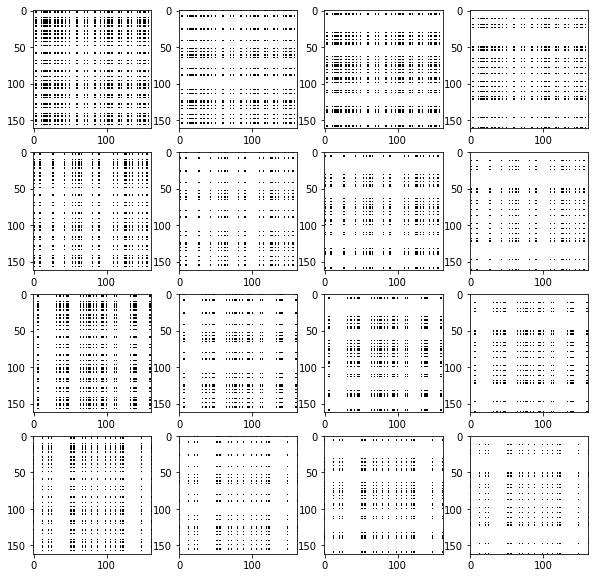

In [137]:
fig,ax =plt.subplots(4,4,figsize=(10,10))
for i in range(4):
    for j in range(4):
        ax[i,j].imshow(convert_to_image(f[filenames[1]+'/seq'][:])[:,:,i*4+j],cmap=cm.Greys)

In [35]:
def convert_to_pics(filename):
    '''
    X: images of 16 channel
    y:sparse match matrix
    '''
    matt = f[filename+'/match'][:].astype('int')
    matmatrix = np.zeros([matt.shape[0],matt.shape[0]])
    for i in range(matt.shape[0]):
        if matt[i] !=0:
            matmatrix[i,matt[i]-1] =1 
    return convert_to_image(f[filename+'/seq'][:]),matmatrix

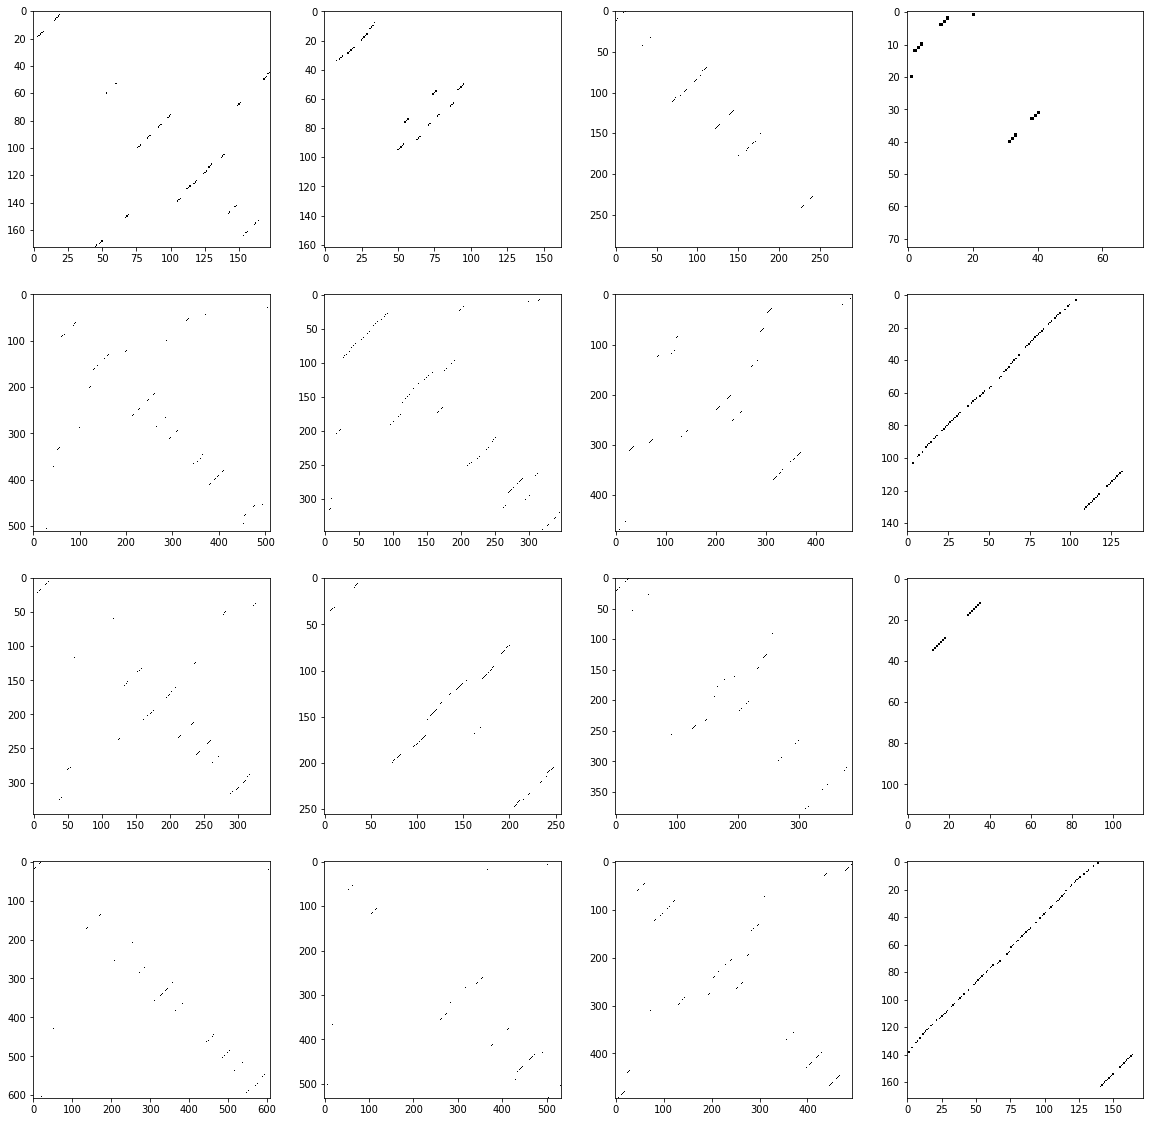

In [182]:
fig,ax =plt.subplots(4,4,figsize=(20,20))
for i in range(4):
    for j in range(4):
        ax[i,j].imshow(convert_to_pics(filenames[i*4+j])[1],cmap=cm.Greys)

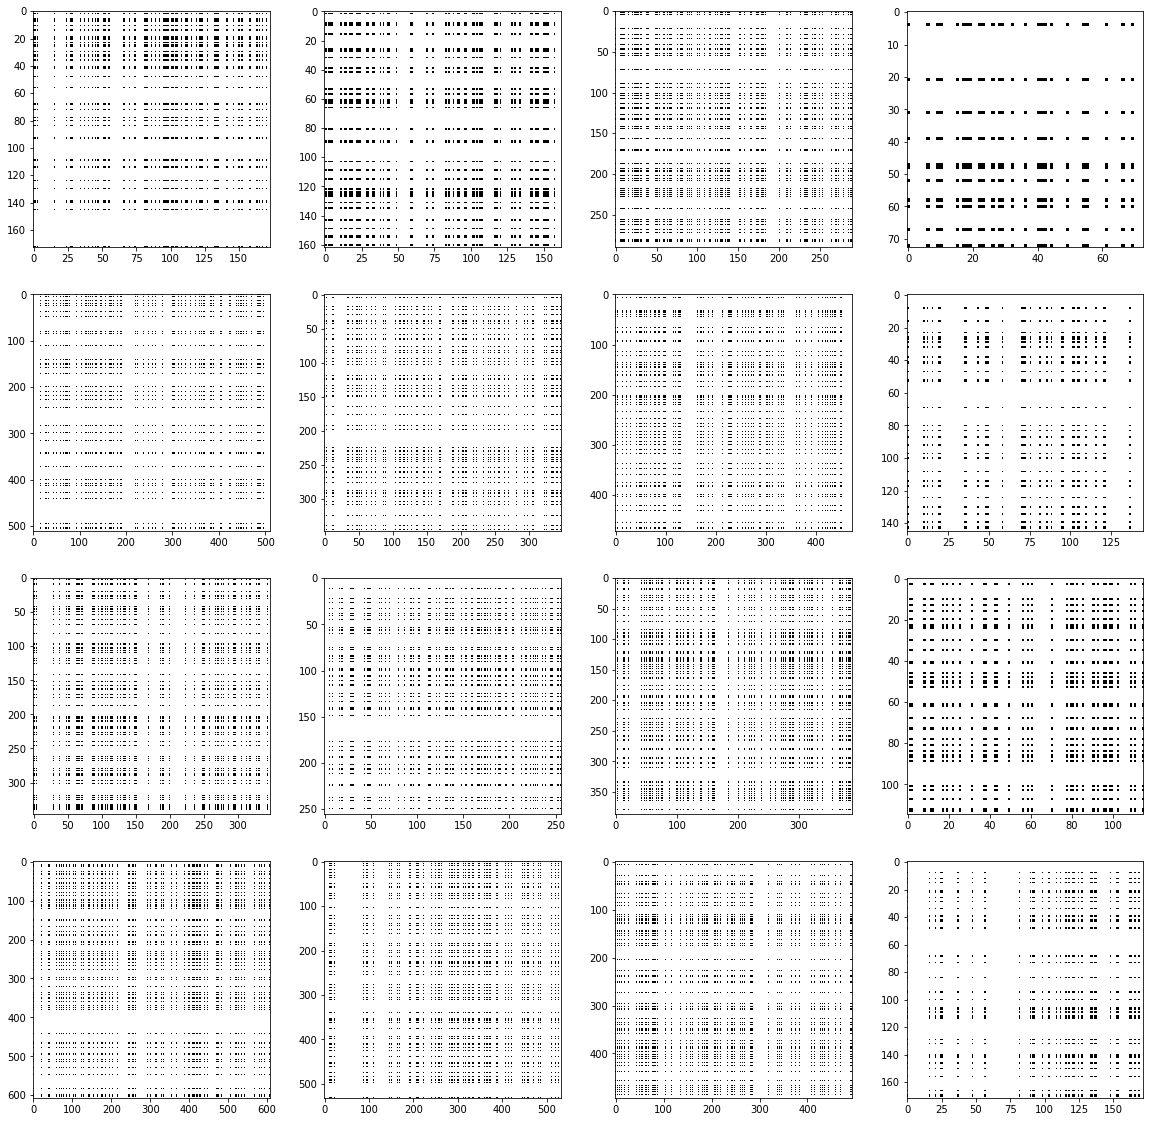

In [186]:
fig,ax =plt.subplots(4,4,figsize=(20,20))
for i in range(4):
    for j in range(4):
        ax[i,j].imshow(convert_to_pics(filenames[i*4+j])[0][:,:,1],cmap=cm.Greys)

In [36]:
with h5py.File('known/2d/pictures_540') as t:
    for i in tqdm(range(540)):
        t.create_group(filenames[i])
        t.create_dataset(filenames[i]+'/X',data=convert_to_pics(filenames[i])[0])
        t.create_dataset(filenames[i]+'/y',data=convert_to_pics(filenames[i])[1])

100%|██████████| 540/540 [00:03<00:00, 177.12it/s]


In [39]:
X = {}
y = {}
with h5py.File('known/2d/pictures_540') as t:
    for i in tqdm(range(540)):
        X[i] = t[filenames[i]+'/X'][:]
        y[i] = t[filenames[i]+'/y'][:]

100%|██████████| 540/540 [00:01<00:00, 443.78it/s]


In [41]:
X[0].shape

(173, 173, 16)

In [42]:
y[0].shape

(173, 173)

不能抽取，按顺序截取 <br>
如果y的非零比例小于某个值就去除 （如何设置阈值？）统计一下大概情况 <br>
行列，分别取128长度的片段，索引出X_train,y_train
153558
取153558张，每个序列多长取多少张，540:   400，40，100分别训练，验证，测试 <br>
如果只取前面的显然是不合理的，所有正反都要取，所以生成index应该包括倒着的  <br>
count = y[0].shape[0]
i < count
np.arange(i,128+i)
np.arange(-i,-i-128)

In [45]:
count=0
for i in range(540):
    count+=y[i].shape[0]

In [59]:
sum([sum(y[i]) for i in range(540)])/sum([(y[i].shape[0])**2 for i in range(540)])
1/0.0013666500330246183

0.0013666500330246183

imbalance:0.0013666500330246183

In [56]:
os.listdir('data/new/alldata/train/')

['train_Lu_2016_invitro_hg38_all_0',
 'train_Lu_2016_invivo_hg38_all_0',
 'train_Spitale_2015_invitro_all_0',
 'train_Spitale_2015_invitro_all_1',
 'train_Spitale_2015_invitro_all_2',
 'train_Spitale_2015_invitro_all_3',
 'train_Spitale_2015_invitro_all_4',
 'train_Spitale_2015_invitro_all_5',
 'train_Spitale_2015_invitro_all_6',
 'train_Spitale_2015_invitro_all_7',
 'train_Spitale_2015_invitro_all_8',
 'train_Spitale_2015_invitro_all_9',
 'train_Spitale_2015_invitro_all_10',
 'train_Spitale_2015_invitro_all_11',
 'train_Spitale_2015_invitro_all_12',
 'train_Spitale_2015_invivo_all_0',
 'train_Spitale_2015_invivo_all_1',
 'train_Spitale_2015_invivo_all_2']

In [63]:
y[0].shape[0] - 128

45

In [73]:
number = y[0].shape[0]
count = number - 128
posstart = np.arange(count)
np.random.shuffle(posstart)
posend = posstart+128

In [90]:
rowind = np.random.choice(count)
colind = np.random.choice(count)
X[0][posstart[rowind]:posend[rowind],posstart[colind]:posend[colind]].shape
y[0][posstart[rowind]:posend[rowind],posstart[colind]:posend[colind]].shape

(128, 128)

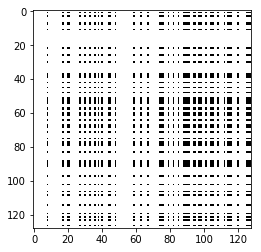

In [88]:
imshow(X[0][posstart[rowind]:posend[rowind],posstart[colind]:posend[colind],0],cmap=cm.Greys)

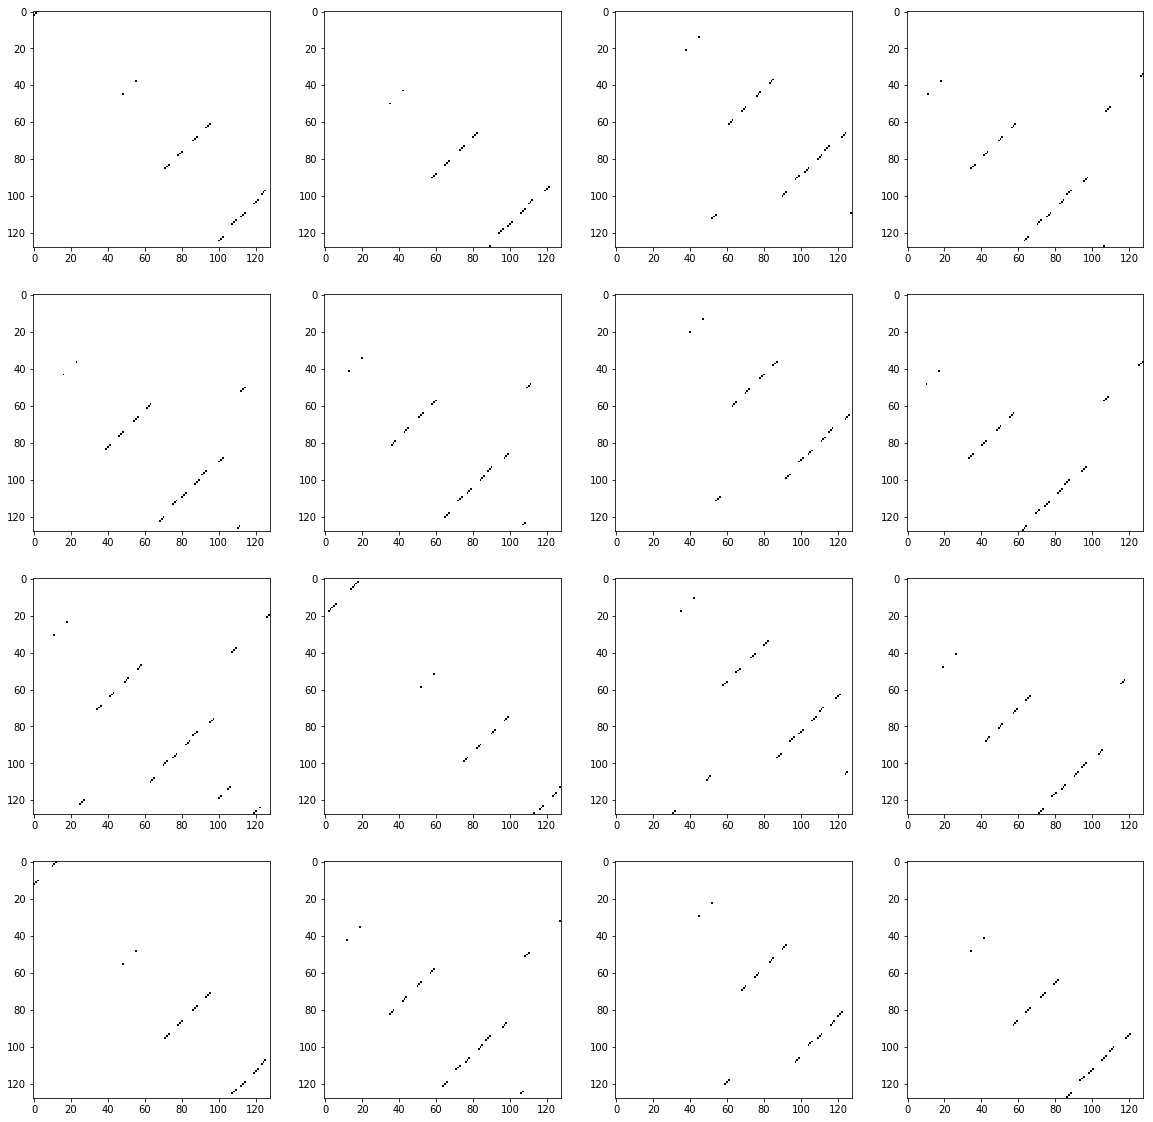

In [99]:
fig,ax =plt.subplots(4,4,figsize=(20,20))
for i in range(4):
    for j in range(4):
        rowind = np.random.choice(count)
        colind = np.random.choice(count)
        ax[i,j].imshow(y[0][posstart[rowind]:posend[rowind],posstart[colind]:posend[colind]],cmap=cm.Greys)

In [102]:
np.arange(-count,0)

array([-45, -44, -43, -42, -41, -40, -39, -38, -37, -36, -35, -34, -33,
       -32, -31, -30, -29, -28, -27, -26, -25, -24, -23, -22, -21, -20,
       -19, -18, -17, -16, -15, -14, -13, -12, -11, -10,  -9,  -8,  -7,
        -6,  -5,  -4,  -3,  -2,  -1])

In [119]:
negend = np.arange(-count,0)
np.random.shuffle(negend)
negstart = negend-128

In [120]:
rowind_ = np.random.choice(count)
colind_ = np.random.choice(count)
X[0][negstart[rowind_]:negend[rowind_],negstart[colind_]:negend[colind_]].shape
y[0][negstart[rowind_]:negend[rowind_],negstart[colind_]:negend[colind_]].shape

(128, 128)

每次随机挑两对，作为行和列的起止 <br>
有很多都小于128，但是不想都补成一样长，所以用可变卷积，每个winsize是一半好了！

In [167]:
def yield_from_seq(X,y):
    ''' get a seq's produced X and y: length*length*16 and length*length
    produce: X: length*128*128*16  y: length*128*128 '''
    number = y.shape[0]
    if number >=128:
        winsize = 128
    else:
        winsize =32
    count = number - winsize
    newarr_x = np.ndarray([number/2*2,winsize,winsize,16])
    newarr_y = np.ndarray([number/2*2,winsize,winsize])
    posstart = np.arange(count)
    np.random.shuffle(posstart)
    posend = posstart+winsize
    negend = np.arange(-count,0)
    np.random.shuffle(negend)
    negstart = negend-winsize
    for i in range(number/2*2):
        if i < number/2:
            rowind = np.random.choice(count)
            colind = np.random.choice(count)
            newarr_x[i] = X[posstart[rowind]:posend[rowind],posstart[colind]:posend[colind]]
            newarr_y[i] = y[posstart[rowind]:posend[rowind],posstart[colind]:posend[colind]]
    
        else:
            rowind_ = np.random.choice(count)
            colind_ = np.random.choice(count)
            newarr_x[i]=X[negstart[rowind_]:negend[rowind_],negstart[colind_]:negend[colind_]]
            newarr_y[i]=y[negstart[rowind_]:negend[rowind_],negstart[colind_]:negend[colind_]]
    return newarr_x,newarr_y

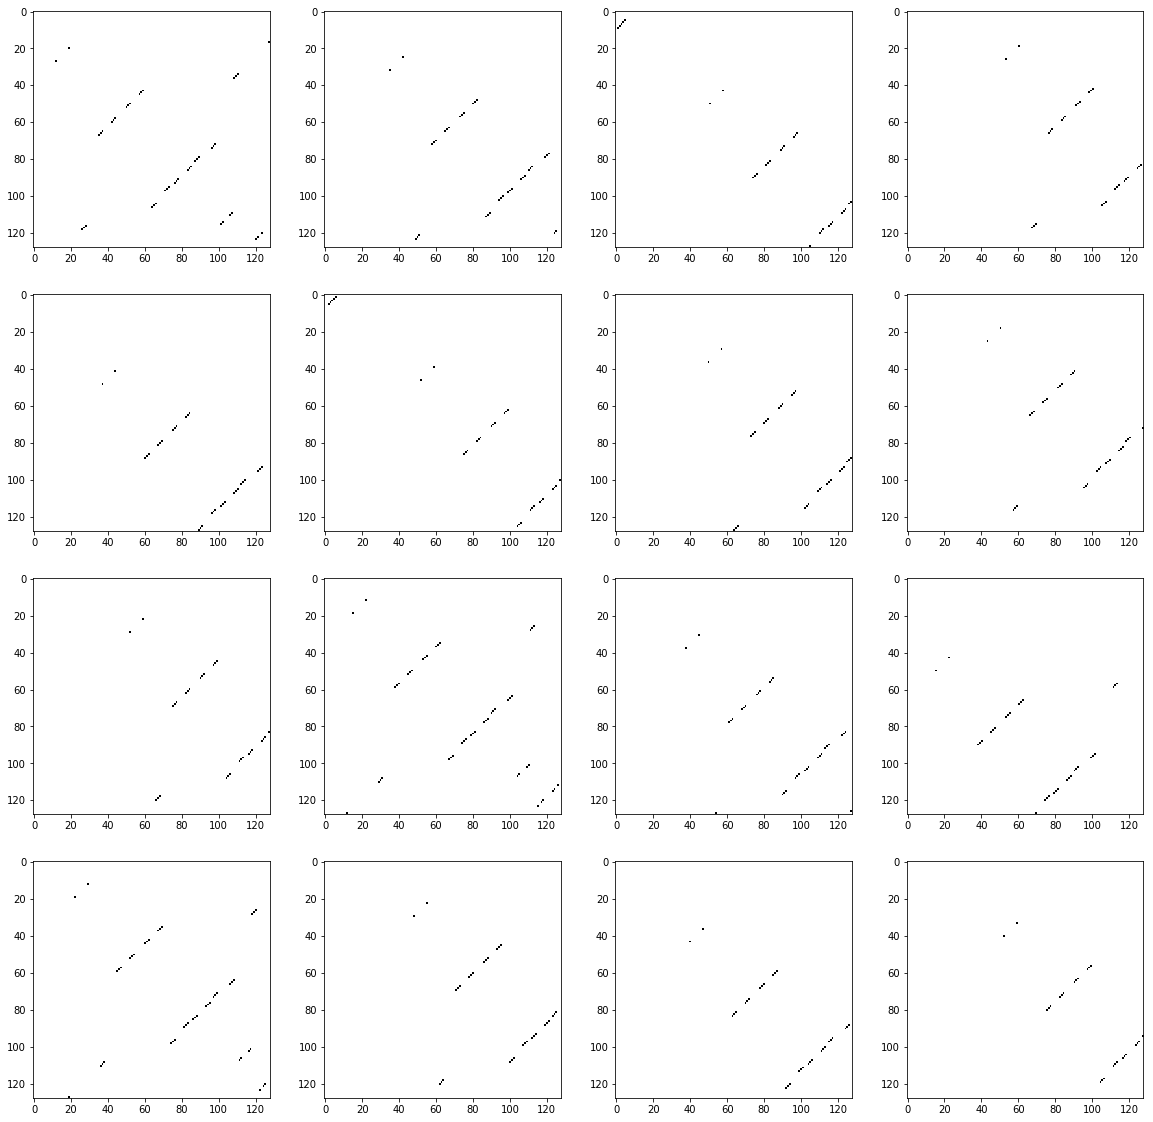

In [135]:
fig,ax =plt.subplots(4,4,figsize=(20,20))
for i in range(4):
    for j in range(4):
        ax[i,j].imshow(yield_from_seq(X[0],y[0])[1][20+4*i+j],cmap=cm.Greys)

In [160]:
for i in range(540):
    if y[i].shape[0] <128:
        print y[i].shape[0]

73
115
116
116
120
120
121
124
114
119
120
127
124
112
103
121
119
110
119
120
124
121
125
120
90
91
56
118
107
99
79
102
106
58
90
86
85
86
107
105
98
35
100
99
99
108
97
66
101
64
53
89
114
58
105
103
88
77
81
101
104
97
127
102
59
91
98
92
74
81
90
106
98
99
114
74
62
101
90
99
57
65
66
96
98
100
117
102
73
71
76
72
76
62
70
74
75
70
72
68
65
70
74
75
76
76
72
77
75
76
67
85
84
83
85
87
74
85
77
76
64
75
77
76
75
76
75
74
54
57
67
72
92
93
86
67
85
78
74
72
74
70
76
77
72
88
74
77
62
65
58
60
58
77
72


In [162]:
yield_from_seq(X[400],y[400])

(array([[[[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 1., 0., ..., 0., 0., 0.],
          ...,
          [0., 1., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 1., 0., 0.],
          [0., 1., 0., ..., 0., 0., 0.]],
 
         [[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 1.],
          [0., 0., 0., ..., 0., 0., 0.]],
 
         [[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 1.],
          [0., 0., 0., ..., 0., 0., 0.]],
 
         ...,
 
         [[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 1., ..., 0., 0., 0.],
          ...,
          [0., 0., 1., ..., 0., 0., 0.],
          [0.

In [168]:
with h5py.File('known/2d/training.hdf5') as f:
    for i in tqdm(train):
        trainx,trainy= data=yield_from_seq(X[i],y[i])
        f.create_dataset(str(i)+'/X',data=trainx)
        f.create_dataset(str(i)+'/y',data=trainy)


  2%|▏         | 9/400 [00:02<01:40,  3.89it/s]
Exception in thread Thread-8:
Traceback (most recent call last):
  File "/home/chenxupeng/apps/anaconda2/lib/python2.7/threading.py", line 801, in __bootstrap_inner
    self.run()
  File "/home/chenxupeng/apps/anaconda2/lib/python2.7/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/chenxupeng/apps/anaconda2/lib/python2.7/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration


100%|██████████| 400/400 [05:38<00:00,  1.18it/s]


In [169]:
with h5py.File('known/2d/test.hdf5') as f:
    for i in tqdm(test):
        testx,testy= data=yield_from_seq(X[i],y[i])
        f.create_dataset(str(i)+'/X',data=testx)
        f.create_dataset(str(i)+'/y',data=testy)

100%|██████████| 100/100 [02:01<00:00,  1.22s/it]


In [170]:
with h5py.File('known/2d/valid.hdf5') as f:
    for i in tqdm(valid):
        validx,validy= data=yield_from_seq(X[i],y[i])
        f.create_dataset(str(i)+'/X',data=validx)
        f.create_dataset(str(i)+'/y',data=validy)

100%|██████████| 40/40 [00:46<00:00,  1.17s/it]


In [ ]:
class_weight = {0 : 1.,1: 731.}
class_weight = class_weight

In [176]:
f= h5py.File('known/2d/training.hdf5')

In [181]:
f['0/X'][:].shape
f['0/y'][:].shape

(172, 128, 128)

In [3]:
a = (3,12,3)

In [1]:
cd /home/chenxupeng/projects/deepshape

/home/chenxupeng/projects/deepshape


In [5]:
import sys,os,errno,gc
sys.path.append('bin')
from second_structure_unet import *
import numpy as np
import datetime
import argparse
from glob import glob
import pandas as pd
import h5py
from tqdm import tqdm
from keras.callbacks import TensorBoard
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  # so the IDs match nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"] = '4'
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
import numpy as np
import keras
from keras.models import Model
from keras import losses
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.core import Dropout, Activation,Reshape,Flatten,Dense
from keras import backend as K
from keras.layers.merge import concatenate
from keras.layers import Lambda, Dot
import tensorflow as tf

Using TensorFlow backend.


In [6]:
INPUT_CHANNELS

16

In [7]:
def UNET_128(dropout_val=dropout_val, batch_norm=True):
    inputs = Input((None, None, INPUT_CHANNELS))
    axis = 3
    filters = 32

    conv_128 = double_conv_layer(inputs, filters, dropout_val, batch_norm)
    pool_64 = MaxPooling2D(pool_size=(2, 2))(conv_128)

    conv_64 = double_conv_layer(pool_64, 2*filters, dropout_val, batch_norm)
    pool_32 = MaxPooling2D(pool_size=(2, 2))(conv_64)

    conv_32 = double_conv_layer(pool_32, 4*filters, dropout_val, batch_norm)
    pool_16 = MaxPooling2D(pool_size=(2, 2))(conv_32)

    conv_16 = double_conv_layer(pool_16, 8*filters, dropout_val, batch_norm)
    pool_8 = MaxPooling2D(pool_size=(2, 2))(conv_16)

    conv_8 = double_conv_layer(pool_8, 16*filters, dropout_val, batch_norm)
    pool_4 = MaxPooling2D(pool_size=(2, 2))(conv_8)

    conv_4 = double_conv_layer(pool_4, 32*filters, dropout_val, batch_norm)

    up_8 = concatenate([UpSampling2D(size=(2, 2))(conv_4), conv_8], axis=axis)
    up_conv_8 = double_conv_layer(up_8, 16*filters, dropout_val, batch_norm)

    up_16 = concatenate([UpSampling2D(size=(2, 2))(up_conv_8), conv_16], axis=axis)
    up_conv_16 = double_conv_layer(up_16, 8*filters, dropout_val, batch_norm)

    up_32 = concatenate([UpSampling2D(size=(2, 2))(up_conv_16), conv_32], axis=axis)
    up_conv_32 = double_conv_layer(up_32, 4*filters, dropout_val, batch_norm)

    up_64 = concatenate([UpSampling2D(size=(2, 2))(up_conv_32), conv_64], axis=axis)
    up_conv_64 = double_conv_layer(up_64, 2*filters, dropout_val, batch_norm)

    up_128 = concatenate([UpSampling2D(size=(2, 2))(up_conv_64), conv_128], axis=axis)
    up_conv_128 = double_conv_layer(up_128, filters, 0, batch_norm)

    conv_final = Conv2D(OUTPUT_MASK_CHANNELS, (1, 1))(up_conv_128)
    conv_final = BatchNormalization(axis=axis)(conv_final)
    conv_final = Activation('sigmoid',name = 'last_activation')(conv_final)

    #to use class weight the dimension must be no more than 3d
    flatten = Lambda(lambda x: K.batch_flatten(x))(conv_final)
    #softmax=Lambda(lambda x: tf.exp(x) / tf.reduce_sum(tf.exp(x), axis=-1))(flatten)
    #shapeofflatten = flatten._keras.shape
    #soft = Lambda(lambda x: Dense(x,2, activation='softmax'))(flatten)
    #flatten =Flatten(input_shape = (None,None,1))(conv_final)
    #dense = Dense(shapeofflatten,activation='softmax')
    model = Model(inputs,flatten, name="ZF_UNET_128")
    return model

def binary_crossentropy_squeeze(y_true, y_pred):
    loss = K.mean(K.binary_crossentropy(y_true, y_pred), axis=-1)
    return loss

In [73]:
def focal_loss_nan(gamma=2., alpha=731):
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = K.where(K.equal(y_true, 1), y_pred, K.ones_like(y_pred))
        pt_0 = K.where(K.equal(y_true, 0), y_pred, K.zeros_like(y_pred))
        return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1))-K.sum(1 * K.pow( pt_0, gamma) * K.log(1. - pt_0))
    return focal_loss_fixed

In [10]:
model = UNET_128()
model.compile(optimizer=Adam(lr=1e-4),loss=weighthed_binary_ce_loss_nan(731), metrics=['accuracy','MSE'])

In [3]:
with h5py.File('known/2d/training.hdf5') as f:
    xtrain = f['0/X'][:]
    ytrain = f['0/y'][:]

In [43]:
xtrain.shape

(172, 128, 128, 16)

In [81]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_23 (InputLayer)           (None, None, None, 1 0                                            
__________________________________________________________________________________________________
conv2d_507 (Conv2D)             (None, None, None, 3 4640        input_23[0][0]                   
__________________________________________________________________________________________________
batch_normalization_507 (BatchN (None, None, None, 3 128         conv2d_507[0][0]                 
__________________________________________________________________________________________________
activation_485 (Activation)     (None, None, None, 3 0           batch_normalization_507[0][0]    
__________________________________________________________________________________________________
conv2d_508

In [9]:
def weighthed_binary_ce_loss_nan(alpha):
    #not_nan = tf.logical_not(tf.is_nan(y_true))
    def celoss(y_true, y_pred):
        zero = K.equal(y_true , K.zeros((1,)))
        one = K.equal(y_true , K.ones((1,)))
        weights = np.array([1,alpha])
        y_true_0 = tf.boolean_mask(y_true, zero)
        y_pred_0 = tf.boolean_mask(y_pred, zero)
        y_true_1 = tf.boolean_mask(y_true, one)
        y_pred_1 = tf.boolean_mask(y_pred, one)
        loss_0 = - y_true_0 * K.log(y_pred_0) * K.variable(weights[0])
        loss_1 = - y_true_1 * K.log(y_pred_1) * K.variable(weights[1])
        loss = K.sum(loss_0, -1) +K.sum(loss_1,-1)
        return loss
    return celoss
keras.losses.weighthed_binary_ce_loss_nan = weighthed_binary_ce_loss_nan

In [84]:
def weighthed_mae_loss_nan(alpha):
    #not_nan = tf.logical_not(tf.is_nan(y_true))
    def maeloss(y_true, y_pred):
        zero = K.equal(y_true , K.zeros((1,)))
        one = K.equal(y_true , K.ones((1,)))
        weights = np.array([1,alpha])
        y_true_0 = tf.boolean_mask(y_true, zero)
        y_pred_0 = tf.boolean_mask(y_pred, zero)
        y_true_1 = tf.boolean_mask(y_true, one)
        y_pred_1 = tf.boolean_mask(y_pred, one)
        loss_0 = K.mean(K.abs(y_pred_0 - y_true_0), axis=-1) * K.variable(weights[0])
        loss_1 = K.mean(K.abs(y_pred_1 - y_true_1), axis=-1) * K.variable(weights[1])
        return loss_0+loss_1
    return maeloss
keras.losses.weighthed_mae_loss_nan = weighthed_mae_loss_nan

In [4]:
ytrain[0].reshape(ytrain[0].shape[0],-1).astype('int').shape

(128, 128)

In [12]:
model.fit(xtrain,ytrain.reshape(ytrain.shape[0],-1).astype('int'))

/home/chenxupeng/apps/anaconda2/lib/python2.7/site-packages/tensorflow/python/ops/gradients_impl.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/1
172/172 [==============================] - 7s 43ms/step - loss: 581047.0465 - acc: 0.0000e+00 - mean_squared_error: 0.2918


In [13]:
pred = model.predict(xtrain)
pred = pred.reshape(pred.shape[0],128,128)
pred[pred >0.5]=1
pred[pred <=0.5]=0
mask_1 = np.where(ytrain ==1)
mask_0 = np.where(ytrain ==0)
TP = float(np.where(pred[mask_1] ==1)[0].shape[0])   #mask_1 pred[mask_1] ==1
TN = float(np.where(pred[mask_0] ==0)[0].shape[0])   #mask_0 pred[mask_0] ==0
FP = float(np.where(pred[mask_0] ==1)[0].shape[0])   #mask_0 pred[mask_0] ==1
FN = float(np.where(pred[mask_1] ==0)[0].shape[0])   #mask_1 pred[mask_1] ==0
#TP A FP B  FN C TN D
Sensitivity =  TP/(TP+FN) * 100
Specificity: TN/(TN+FP) * 100
PPV =  TP/(TP+FP) * 100
NPV =  TN/(TN+FN) * 100

1 - np.sum(np.abs(ytrain -pred)) / float(ytrain.ravel().shape[0])

In [43]:
TP+TN+FP+FN
print TP,TN,FP,FN

2818048

from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
encoder.fit_transform(ytrain.reshape(ytrain.shape[0],-1)[0])
from sklearn.utils.class_weight import compute_class_weight
class_weight_list = compute_class_weight('balanced', np.unique(ytrain.reshape(ytrain.shape[0],-1)[0]), ytrain.reshape(ytrain.shape[0],-1)[0])
class_weight = dict(zip(np.unique(ytrain.reshape(ytrain.shape[0],-1)[0]), class_weight_list))
keras.utils.to_categorical(ytrain.reshape(ytrain.shape[0],-1)[0], 2) 

In [54]:
training = np.loadtxt('known/2d/training_set').astype('int')

In [56]:
xtrain = {}
ytrain={}
for i in tqdm(range(400)):
    with h5py.File('known/2d/training.hdf5') as f:
        xtrain[i] = f[str(training[i])+'/X'][:]
        ytrain[i] = f[str(training[i])+'/y'][:]

100%|██████████| 400/400 [11:51<00:00,  1.78s/it]


In [57]:
Xtrain = np.array([value for (key,value) in xtrain.iteritems()])
ytrain = np.array([value for (key,value) in ytrain.iteritems()])

In [66]:
Xtrain[0].shape

(352, 128, 128, 16)

In [67]:
Xtrain[1].shape

(76, 32, 32, 16)

In [ ]:
np.concatenate((Xtrain[0],Xtrain[1]),axis=0).shape

In [ ]:
np.concatenate(([Xtrain[i] for i in range(5)]),axis=0).shape

In [68]:
valid = np.loadtxt('known/2d/valid_set').astype('int')
xvalid = {}
yvalid={}
for i in tqdm(range(100)):
    with h5py.File('known/2d/valid.hdf5') as f:
        xvalid [i] = f[str(valid[i])+'/X'][:]
        yvalid [i] = f[str(valid[i])+'/y'][:]
Xvalid = np.array([value for (key,value) in xvalid.iteritems()])
yvalid = np.array([value for (key,value) in yvalid.iteritems()])

 40%|████      | 40/100 [02:20<03:30,  3.51s/it]

IndexError: index 40 is out of bounds for axis 0 with size 40

In [ ]:
test = np.loadtxt('known/2d/test_set').astype('int')
xtest = {}
ytest={}
for i in tqdm(range(40)):
    with h5py.File('known/2d/test_set.hdf5') as f:
        xtest [i] = f[str(test[i])+'/X'][:]
        ytest [i] = f[str(test[i])+'/y'][:]
Xtest = np.array([value for (key,value) in xtest.iteritems()])
ytest = np.array([value for (key,value) in ytest.iteritems()])

In [ ]:
with h5py.File('known/2d/wholetraining.hdf5') as f:
    f.create_dataset('X',data = Xtrain)
    f.create_dataset('y',data = ytrain)
with h5py.File('known/2d/wholevalid.hdf5') as f:
    f.create_dataset('X',data = Xvalid)
    f.create_dataset('y',data = yvalid)
with h5py.File('known/2d/wholetest.hdf5') as f:
    f.create_dataset('X',data = Xtest)
    f.create_dataset('y',data = ytest)